In [9]:
from dotenv import load_dotenv
import os
from pathlib import Path

env_path = Path('.') / '.env'
load_dotenv(dotenv_path=env_path)

# reference: https://stackoverflow.com/questions/16924471/difference-between-os-getenv-and-os-environ-get
try:
    api_key = os.environ["GOOGLE_API_KEY"]
    os.environ["GOOGLE_GENAI_USE_VERTEXAI"] = "FALSE"
    print("✅ Gemini API key setup complete.")
except Exception as e:
    print(f"🔑 Authentication Error: Please make sure you have added 'GOOGLE_API_KEY' in .env file. Details: {e}")

🔑 Authentication Error: Please make sure you have added 'GOOGLE_API_KEY' in .env file. Details: 'GOOGLE_API_KEY'


In [2]:
from google.genai import types

from google.adk.agents import LlmAgent
from google.adk.models.google_llm import Gemini
from google.adk.runners import InMemoryRunner


from google.adk.sessions import InMemorySessionService
from google.adk.tools import google_search, AgentTool, ToolContext
from google.adk.code_executors import BuiltInCodeExecutor

print("✅ ADK components imported successfully.")

✅ ADK components imported successfully.


In [3]:
# helper functions
def show_python_code_and_result(response):
    for i in range(len(response)):
        # Check if the response contains a valid function call result from the code executor
        if (
            (response[i].content.parts)
            and (response[i].content.parts[0])
            and (response[i].content.parts[0].function_response)
            and (response[i].content.parts[0].function_response.response)
        ):
            response_code = response[i].content.parts[0].function_response.response
            if "result" in response_code and response_code["result"] != "```":
                if "tool_code" in response_code["result"]:
                    print(
                        "Generated Python Code >> ",
                        response_code["result"].replace("tool_code", ""),
                    )
                else:
                    print("Generated Python Response >> ", response_code["result"])


print("✅ Helper functions defined.")

✅ Helper functions defined.


In [4]:
retry_config = types.HttpRetryOptions(
    attempts=5,  # Maximum retry attempts
    exp_base=7,  # Delay multiplier
    initial_delay=1,
    http_status_codes=[429, 500, 503, 504],  # Retry on these HTTP errors
)

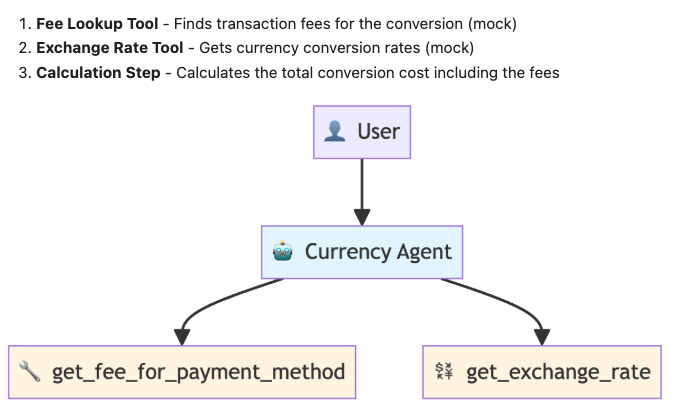

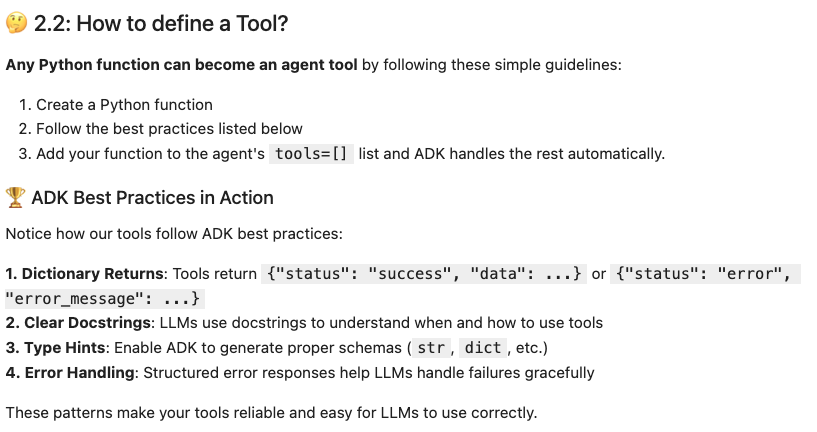

In [5]:
# Pay attention to the docstring, type hints, and return value.
def get_fee_for_payment_method(method: str) -> dict:
    """Looks up the transaction fee percentage for a given payment method.

    This tool simulates looking up a company's internal fee structure based on
    the name of the payment method provided by the user.

    Args:
        method: The name of the payment method. It should be descriptive,
                e.g., "platinum credit card" or "bank transfer".

    Returns:
        Dictionary with status and fee information.
        Success: {"status": "success", "fee_percentage": 0.02}
        Error: {"status": "error", "error_message": "Payment method not found"}
    """
    # This simulates looking up a company's internal fee structure.
    fee_database = {
        "platinum credit card": 0.02,  # 2%
        "gold debit card": 0.035,  # 3.5%
        "bank transfer": 0.01,  # 1%
    }

    fee = fee_database.get(method.lower())
    if fee is not None:
        return {"status": "success", "fee_percentage": fee}
    else:
        return {
            "status": "error",
            "error_message": f"Payment method '{method}' not found",
        }


print("✅ Fee lookup function created")
print(f"💳 Test: {get_fee_for_payment_method('platinum credit card')}")

✅ Fee lookup function created
💳 Test: {'status': 'success', 'fee_percentage': 0.02}


In [6]:
def get_exchange_rate(base_currency: str, target_currency: str) -> dict:
    """Looks up and returns the exchange rate between two currencies.

    Args:
        base_currency: The ISO 4217 currency code of the currency you
                       are converting from (e.g., "USD").
        target_currency: The ISO 4217 currency code of the currency you
                         are converting to (e.g., "EUR").

    Returns:
        Dictionary with status and rate information.
        Success: {"status": "success", "rate": 0.93}
        Error: {"status": "error", "error_message": "Unsupported currency pair"}
    """

    # Static data simulating a live exchange rate API
    # In production, this would call something like: requests.get("api.exchangerates.com")
    rate_database = {
        "usd": {
            "eur": 0.93,  # Euro
            "jpy": 157.50,  # Japanese Yen
            "inr": 83.58,  # Indian Rupee
        }
    }

    # Input validation and processing
    base = base_currency.lower()
    target = target_currency.lower()

    # Return structured result with status
    rate = rate_database.get(base, {}).get(target)
    if rate is not None:
        return {"status": "success", "rate": rate}
    else:
        return {
            "status": "error",
            "error_message": f"Unsupported currency pair: {base_currency}/{target_currency}",
        }


print("✅ Exchange rate function created")
print(f"💱 Test: {get_exchange_rate('USD', 'EUR')}")

✅ Exchange rate function created
💱 Test: {'status': 'success', 'rate': 0.93}


In [1]:
# Currency agent with custom function tools
currency_agent = LlmAgent(
    name="currency_agent",
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    instruction="""You are a smart currency conversion assistant.

    For currency conversion requests:
    1. Use `get_fee_for_payment_method()` to find transaction fees
    2. Use `get_exchange_rate()` to get currency conversion rates
    3. Check the "status" field in each tool's response for errors
    4. Calculate the final amount after fees based on the output from `get_fee_for_payment_method` and `get_exchange_rate` methods and provide a clear breakdown.
    5. First, state the final converted amount.
        Then, explain how you got that result by showing the intermediate amounts. Your explanation must include: the fee percentage and its
        value in the original currency, the amount remaining after the fee, and the exchange rate used for the final conversion.

    If any tool returns status "error", explain the issue to the user clearly.
    """,
    tools=[get_fee_for_payment_method, get_exchange_rate],
)

print("✅ Currency agent created with custom function tools")
print("🔧 Available tools:")
print("  • get_fee_for_payment_method - Looks up company fee structure")
print("  • get_exchange_rate - Gets current exchange rates")

NameError: name 'LlmAgent' is not defined

In [8]:
# Test the currency agent
currency_runner = InMemoryRunner(agent=currency_agent)
_ = await currency_runner.run_debug(
    "I want to convert 500 US Dollars to Euros using my Platinum Credit Card. How much will I receive?"
)


 ### Created new session: debug_session_id

User > I want to convert 500 US Dollars to Euros using my Platinum Credit Card. How much will I receive?


ValueError: Missing key inputs argument! To use the Google AI API, provide (`api_key`) arguments. To use the Google Cloud API, provide (`vertexai`, `project` & `location`) arguments.